In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
plt.rcParams["figure.figsize"] = [20,10]

In [3]:
from NetEmbs.DataProcessing.normalize import normalize
from NetEmbs.DataProcessing.connect_db import *
from NetEmbs.GenerateData.complex_df import sales_collections
d=normalize(upload_data(limit=10))

In [4]:
from NetEmbs.FSN.graph import FSN

In [5]:
d = upload_data()

In [6]:
d.head(10)

,ID,Name,FA_Name,Value,Debit,Credit
0,1,Revenue_5,Revenue,-558.000000,0.000000,558.000000
1,1,Tax_5,Tax,-111.601702,0.000000,111.601702
2,1,hqmxna_5,hqmxna,1.042784,1.042784,0.000000
3,1,mftiuo_5,mftiuo,2.835331,2.835331,0.000000
4,1,TradeReceivables5,TradeReceivables,665.723586,665.723586,0.000000
5,2,TradeReceivables_5,TradeReceivables,-665.723586,0.000000,665.723586
6,2,hqmxna,hqmxna,-1.042784,0.000000,1.042784
7,2,mftiuo,mftiuo,-2.835331,0.000000,2.835331
8,2,Cash8,Cash,669.601702,669.601702,0.000000
9,3,Revenue_3,Revenue,-866.000000,0.000000,866.000000


In [8]:
fsn = FSN()
fsn.build(normalize(d))
fsn.nodes()

NodeView((1, 2, 3, 'Revenue_5', 'Tax_5', 'hqmxna_5', 'mftiuo_5', 'TradeReceivables5', 'TradeReceivables_5', 'hqmxna', 'mftiuo', 'Cash8', 'Revenue_3'))

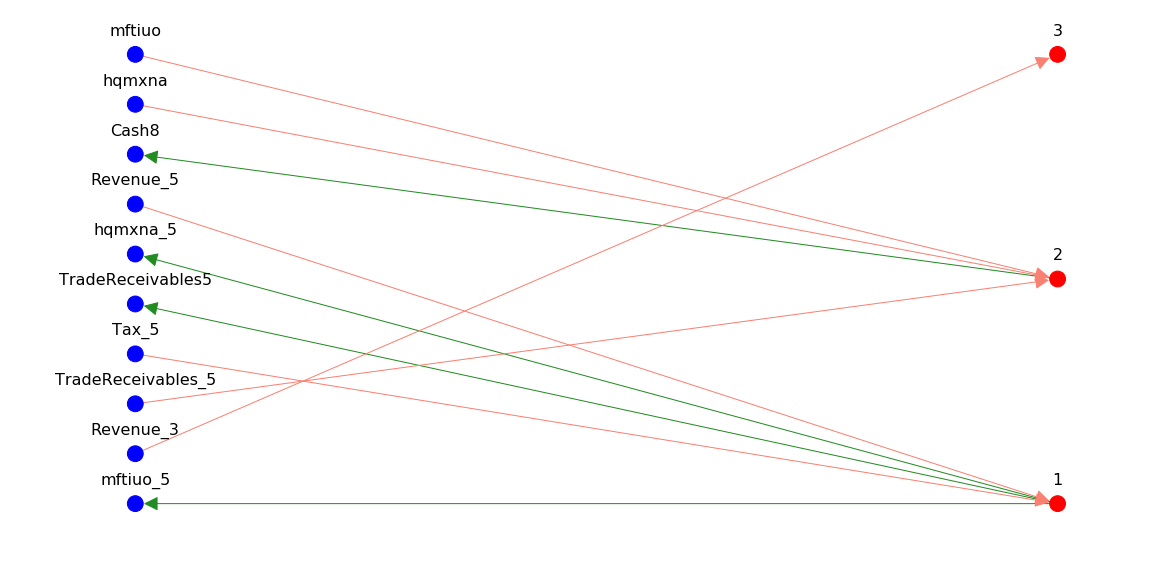

In [9]:
from NetEmbs.Vis.plots import plotFSN
plotFSN(fsn)

## Different sampling strategies

In [ ]:
from scipy.special import softmax
def def_step(G, vertex, direction="IN", weighted=False, debug=False, **kwargs):
#     One step according to the original implementation of RandomWalk by Perozzi et al.
    if vertex==-1:
#         Step cannot be made, return -1
        return -1
    elif not G.has_node(vertex):
        raise ValueError("Vertex {!r} is not in FSN!".format(vertex))
    if direction=="IN":
        ins = G.in_edges(vertex, data=True)
    elif direction=="OUT":
        ins = G.out_edges(vertex, data=True)
    else:
        raise ValueError("Wrong direction argument! {!s} used while IN or OUT are allowed!".format(direction))
    indexes = ["IN", "OUT"]
    if len(ins) > 0:
        if weighted:
            ws = list()
            tmp_vertex = None
            tmp_weight = None
            ws = [edge[-1]["weight"] for edge in ins]
            p_ws = ws / np.sum(ws)
            ins = [edge[indexes.index(direction)] for edge in ins]
            tmp_idx = np.random.choice(range(len(ins)), p=p_ws)
            tmp_vertex = ins[tmp_idx]
            tmp_weight = ws[tmp_idx]
        else:
            ins = [edge[indexes.index(direction)] for edge in ins]
            tmp_vertex = np.random.choice(ins)
        if debug:
            print(tmp_vertex)
        return tmp_vertex
    else:
        return -1

In [ ]:
cur=1
for _ in range(10):
    cur = def_step(fsn, cur)
    print(cur)

In [ ]:
from NetEmbs.FSN.utils import def_step, step
# Default sampling with RandomWalk: follow the direction, uniform transition probability etc.
def randomWalk(G, vertex=None, lenght=3, direction="IN", mode="meta_new", weighted=False, debug=False):
    attempts = 10
    context = list()
    if vertex is None:
        context.append(random.choice(list(G.nodes)))
    else:
        context.append(vertex)
    cur_v = context[-1]
    while len(context)<lenght+1 and attempts>0:
        try:
            if mode=="def":
                new_v = def_step(G, cur_v, direction, weighted, debug=debug)
            elif mode=="meta_def":
                if weighted:
                    new_v = step(G, cur_v, direction, mode=1, debug=debug)
                else:
                    new_v = step(G, cur_v, direction, mode=0, debug=debug)
            elif mode=="meta_new":
                new_v = step(G, cur_v, direction, mode=2, debug=debug)
            attempts-=1
        except nx.NetworkXError:
            break
        if new_v == -1:
            if debug: print("Cannot continue walking... Termination.")
            break
        context.append(new_v)
        cur_v = new_v
    return context

In [ ]:
randomWalk(fsn, 6, 50, mode="meta_new")

## FSN: Financial statement network

[Marcel's FSN from paper] the financial statement network of company A is displayed, where the **238** blue nodes are the financial accounts and the **4643** red nodes are the business processes.

We replace the account names in the journal entries by its parent, for example, if we have a record in a journal entry with account name Product B then that account name will be replaced by the account name Revenue.

Reducing the account set A from 238 nodes to **23 high-level financial statement account nodes** already reduces the complexity of the network to a total of 709 nodes and 2731 edges

### Trade Receivalbe FA
To record a trade receivable, the accounting software creates a debit to the accounts receivable account and a credit to the sales account when you complete an invoice. When the customer eventually pays the invoice, the accounting software records the cash receipt transaction with a debit to the cash account and a credit to the accounts receivable account.

### Modeled BPs
#### Sales
Revenue + Tax -> Trade Receivable